### NLI

A large annotated corpus for learning natural language inference by [Bowman et al.](https://arxiv.org/pdf/1508.05326v1.pdf)

In [ ]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [1]:
ls entailment/data

__MACOSX/  glove.6B.zip  snli_1.0/  snli_1.0.bak.zip  snli_1.0.zip


In [3]:
import os
import zipfile
import io
import numpy as np
from tqdm import tqdm
zip_file_name = 'entailment/data/snli_1.0.zip'
output_file_name = 'snli_1.0/snli_1.0_train.txt'

def load_data(num_samples=10):
    counter = 0
    columns = ['gold_label','sentence1','sentence2']
    indices = [-1, -1, -1]
    data = []
    with zipfile.ZipFile(zip_file_name) as z:
        for info in z.infolist():
            if output_file_name in info.filename:
                # read the file
                print("Reading lines from file {}".format(output_file_name))
                with io.TextIOWrapper(z.open(output_file_name), encoding="utf-8") as f:
                    for line in tqdm(f):
                        terms = line.split('\t')
                        if np.min(indices) == -1: # this is the first line
                            indices = [np.where(np.array(terms) == val)[0] for val in columns]
                            counter += 1
                        else:
                            idx = [i[0] for i in indices]
                            #do not include the '-' label
                            if np.array(terms)[idx][0] != '-':
                                data.append(np.array(terms)[idx])
                                counter += 1
                        if (num_samples > -1) & (counter > num_samples):
                            return data

In [43]:
data = load_data(100000)
print("Read {} records".format(len(data)))

1140it [00:00, 11393.00it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt


100111it [00:04, 22426.91it/s]

Read 100000 records


In [52]:
data

[array(['neutral',
        'A person on a horse jumps over a broken down airplane.',
        'A person is training his horse for a competition.'], dtype='<U161'),
 array(['contradiction',
        'A person on a horse jumps over a broken down airplane.',
        'A person is at a diner, ordering an omelette.'], dtype='<U161'),
 array(['entailment',
        'A person on a horse jumps over a broken down airplane.',
        'A person is outdoors, on a horse.'], dtype='<U161'),
 array(['neutral', 'Children smiling and waving at camera',
        'They are smiling at their parents'], dtype='<U106'),
 array(['entailment', 'Children smiling and waving at camera',
        'There are children present'], dtype='<U106'),
 array(['contradiction', 'Children smiling and waving at camera',
        'The kids are frowning'], dtype='<U106'),
 array(['contradiction',
        'A boy is jumping on skateboard in the middle of a red bridge.',
        'The boy skates down the sidewalk.'], dtype='<U194'),
 array

In [54]:
data = [[d[0], d[1],d[2]] for d in data[:]]

In [55]:
data[:3]

[['neutral',
  'A person on a horse jumps over a broken down airplane.',
  'A person is training his horse for a competition.'],
 ['contradiction',
  'A person on a horse jumps over a broken down airplane.',
  'A person is at a diner, ordering an omelette.'],
 ['entailment',
  'A person on a horse jumps over a broken down airplane.',
  'A person is outdoors, on a horse.']]

##### Prepare the input data

- Tokenize the sentences


In [83]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.4.1


In [57]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w
def build_tokenizer(data):
    #combine the hypothesis and the evidence into one setence with the seperators in between.
    all_texts = [" ".join((preprocess(d[1]),preprocess(d[2]))) for d in data]
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
    lang_tokenizer.fit_on_texts(all_texts)
    return lang_tokenizer

In [58]:
lang_tokenizer = build_tokenizer(data)
hyp_tokens = lang_tokenizer.texts_to_sequences([preprocess(d[1]) for d in data])
hyp_tokens = tf.keras.preprocessing.sequence.pad_sequences(hyp_tokens, padding='post')
evi_tokens = lang_tokenizer.texts_to_sequences([preprocess(d[2]) for d in data])
evi_tokens = tf.keras.preprocessing.sequence.pad_sequences(evi_tokens, padding='post')

In [60]:
hyp_tokens.shape

(100000, 84)

In [61]:
evi_tokens.shape

(100000, 46)

The labels will need to be on hot encoded so that it can be fed into training

In [62]:
labels = [d[0] for d in data]

In [63]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_enc = le.transform(labels)

In [64]:
train_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    train_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(train_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(train_labels)))

A peek a the reshaped labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [65]:
features = np.concatenate((hyp_tokens, evi_tokens), axis = 1)

In [88]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(features, train_labels, test_size=0.3)

In [67]:
target_tensor_train[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [68]:
len(lang_tokenizer.word_index)

16451

#### Prepare the embeddings
Load the glove embeddings

In [69]:
glove_zip_file = "entailment/data/glove.6B.zip"
glove_vectors_file = "glove.6B.100d.txt"
embeddings_index = {}
with zipfile.ZipFile(glove_zip_file) as z:
        for info in z.infolist():
            print(info.filename)
            if glove_vectors_file in info.filename:
                # read the file
                print("Reading lines from file {}".format(glove_vectors_file))
                with io.TextIOWrapper(z.open(glove_vectors_file), encoding="utf-8") as f:
                    for line in f:
                        terms = line.split()
                        word = terms[0]
                        coefs = np.asarray(terms[1:], dtype='float32')
                        
                        embeddings_index[word] = coefs

glove.6B.50d.txt
glove.6B.100d.txt
Reading lines from file glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt


In [76]:
print(data[:1])
print(hyp_tokens[:1])

[['neutral', 'A person on a horse jumps over a broken down airplane.', 'A person is training his horse for a competition.']]
[[   3    2   45   10    2  202  238   83    2 1126   44  771    5    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [75]:
sent = 'A person on a horse jumps over a broken down airplane .'
for word in sent.lower().split(' '):
    print("Index of word '{}' in the tokenized sequence is {}".format(word, lang_tokenizer.word_index.get(word)))

Index of word 'a' in the tokenized sequence is 2
Index of word 'person' in the tokenized sequence is 45
Index of word 'on' in the tokenized sequence is 10
Index of word 'a' in the tokenized sequence is 2
Index of word 'horse' in the tokenized sequence is 202
Index of word 'jumps' in the tokenized sequence is 238
Index of word 'over' in the tokenized sequence is 83
Index of word 'a' in the tokenized sequence is 2
Index of word 'broken' in the tokenized sequence is 1126
Index of word 'down' in the tokenized sequence is 44
Index of word 'airplane' in the tokenized sequence is 771
Index of word '.' in the tokenized sequence is 5


In [77]:
embeddings_index.get('airplane')

array([-1.6905e-01,  2.7387e-01,  5.6794e-01,  1.9879e-03, -1.2258e-01,
       -4.7564e-01,  5.3575e-01,  5.3408e-02,  3.3973e-01,  3.9381e-01,
        5.3866e-01, -7.9248e-02,  2.1101e-01,  3.9848e-01, -2.4034e-01,
       -2.1135e-01,  2.4204e-01,  7.5500e-01,  8.7943e-01,  7.6776e-03,
        2.2761e-01,  1.3173e-01,  2.4464e-01, -7.9466e-01,  5.3546e-01,
       -1.3146e-01, -1.0728e+00,  3.3607e-01,  1.4914e-01, -1.8328e-01,
       -2.7835e-01,  2.2114e-01, -8.6374e-03,  7.1159e-01, -3.7257e-01,
        9.2297e-01,  6.7150e-01,  4.6155e-01,  1.0223e+00,  3.3371e-02,
       -4.2123e-01, -2.5116e-01,  2.3897e-01,  2.9825e-01,  1.9633e-01,
        4.7368e-01,  1.1481e-01, -2.4439e-01, -4.5919e-01, -2.7042e-01,
       -3.1669e-01,  5.7177e-01, -2.9423e-01,  8.1875e-01,  4.4011e-01,
       -7.7701e-01,  8.0021e-02,  8.4484e-01,  2.2236e+00,  2.9603e-01,
        2.6407e-01,  8.9465e-01,  3.3492e-01,  4.6542e-01, -4.2811e-01,
       -3.2176e-01,  6.6258e-02, -1.0479e-01, -7.3056e-01,  3.82

In [78]:
embeddings_index["the"].shape
max_length = embeddings_index["the"].shape[0]
print("max length of sequence is {}".format(max_length))

max length of sequence is 100


In [79]:
embedding_matrix = np.zeros((len(lang_tokenizer.word_index) + 1, max_length))
for word, i in lang_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [80]:
embedding_matrix.shape

(16452, 100)

In [81]:
embedding_matrix[771]

array([-1.69049993e-01,  2.73869991e-01,  5.67939997e-01,  1.98789989e-03,
       -1.22579999e-01, -4.75639999e-01,  5.35749972e-01,  5.34080006e-02,
        3.39729995e-01,  3.93810004e-01,  5.38659990e-01, -7.92480037e-02,
        2.11009994e-01,  3.98479998e-01, -2.40339994e-01, -2.11349994e-01,
        2.42039993e-01,  7.54999995e-01,  8.79429996e-01,  7.67759979e-03,
        2.27610007e-01,  1.31730005e-01,  2.44639993e-01, -7.94659972e-01,
        5.35459995e-01, -1.31459996e-01, -1.07280004e+00,  3.36070001e-01,
        1.49140000e-01, -1.83280006e-01, -2.78349996e-01,  2.21139997e-01,
       -8.63740034e-03,  7.11589992e-01, -3.72570008e-01,  9.22969997e-01,
        6.71500027e-01,  4.61549997e-01,  1.02230000e+00,  3.33710015e-02,
       -4.21229988e-01, -2.51159996e-01,  2.38969997e-01,  2.98249990e-01,
        1.96329996e-01,  4.73679990e-01,  1.14809997e-01, -2.44389996e-01,
       -4.59190011e-01, -2.70420015e-01, -3.16689998e-01,  5.71770012e-01,
       -2.94230014e-01,  

In [84]:
vocab_size= len(lang_tokenizer.word_index)
dim = embedding_matrix.shape[1]
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
inp = keras.Input(shape=(None,))
x1 = embedding_layer(inp)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x1)
x3 = tf.keras.layers.Dense(16, activation='relu')(x2)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model = keras.Model(inp, output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         1645200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 16)                3216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,809,267
Trainable params: 164,067
Non-trainable params: 1,645,200
_____________________________________________

In [85]:
!mkdir -p tmp

In [86]:
ls tmp

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


In [87]:
checkpoint_filepath = 'tmp/checkpoint_bowman'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [89]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [90]:
for example, label in train_dataset.take(1):
    print(example.shape)
    print(example)
    print(label.shape)

(64, 130)
tf.Tensor(
[[  3  16  84 ...   0   0   0]
 [  3   2  63 ...   0   0   0]
 [  3   2   9 ...   0   0   0]
 ...
 [  3   2 887 ...   0   0   0]
 [  3   2 939 ...   0   0   0]
 [  3  16 185 ...   0   0   0]], shape=(64, 130), dtype=int32)
(64, 3)


In [91]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [92]:
history = model.fit(train_dataset, epochs=20,
                    callbacks=[stop_early, model_checkpoint_callback],
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/20
1093/1093 [==============================] - 210s 189ms/step - loss: 1.0121 - accuracy: 0.4789 - val_loss: 0.8743 - val_accuracy: 0.5969
Epoch 2/20
1093/1093 [==============================] - 214s 196ms/step - loss: 0.8627 - accuracy: 0.6046 - val_loss: 0.8212 - val_accuracy: 0.6214
Epoch 3/20
1093/1093 [==============================] - 224s 205ms/step - loss: 0.7943 - accuracy: 0.6482 - val_loss: 0.7832 - val_accuracy: 0.6458
Epoch 4/20
1093/1093 [==============================] - 234s 214ms/step - loss: 0.7450 - accuracy: 0.6747 - val_loss: 0.7818 - val_accuracy: 0.6500
Epoch 5/20
1093/1093 [==============================] - 247s 225ms/step - loss: 0.7073 - accuracy: 0.7004 - val_loss: 0.7463 - val_accuracy: 0.6698
Epoch 6/20
1093/1093 [==============================] - 249s 228ms/step - loss: 0.6720 - accuracy: 0.7152 - val_loss: 0.7509 - val_accuracy: 0.6760
Epoch 7/20
1093/1093 [==============================] - 241s 221ms/step - loss: 0.6377 - accuracy: 0.7341 - val_

Text(0.5, 1.0, 'Metrics for training SNLI dataset, 70K samples (glove 100d)')

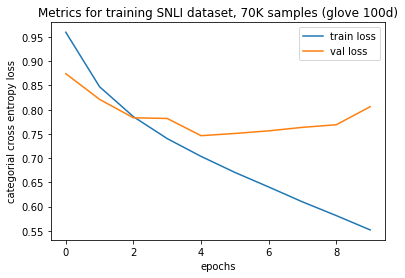

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training SNLI dataset, 70K samples (glove 100d)")
#history.history['loss']

In [94]:
model.load_weights(checkpoint_filepath)
model.evaluate(val_dataset)

468/468 [==============================] - 40s 85ms/step - loss: 0.7687 - accuracy: 0.6780


[0.7687164545059204, 0.6780181527137756]

#### Alternate
Trying the code from [here](https://github.com/songyang0716/NLP/blob/master/natural_language_inference/sentence_encoding_RNN/model.py)
and [concatenate lstm stackoverflow](https://stackoverflow.com/questions/53956998/how-can-i-concatenate-two-lstm-with-keras)

In [174]:
vocab_size= len(lang_tokenizer.word_index)
dim = embedding_matrix.shape[1]
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)

inp1 = keras.Input(shape=(None,))
inp2 = keras.Input(shape=(None,))
x_hyp = embedding_layer(inp1)
x_evi = embedding_layer(inp2)

hyp_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_hyp)
hyp_evi = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_evi)
w = keras.layers.concatenate([hyp_lstm, hyp_evi], axis = 1)

x3 = tf.keras.layers.Dense(16, activation='relu')(w)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model1 = keras.Model(inputs=[inp1, inp2], outputs=output)
model1.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1645200     input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 200)          160800      embedding_1[7][0]          

In [140]:
print(hyp_tokens.shape)
print(evi_tokens.shape)

(100000, 84)
(100000, 46)


In [121]:
from sklearn.model_selection import train_test_split
input_tensor_train_h, input_tensor_val_h, input_tensor_train_e, input_tensor_val_e, target_tensor_train, target_tensor_val = train_test_split(hyp_tokens, evi_tokens, train_labels, test_size=0.3)

In [129]:
print(input_tensor_train_h.shape)
print(input_tensor_val_h.shape)
print(input_tensor_train_e.shape)
print(input_tensor_val_e.shape)
print(target_tensor_train.shape)
print(target_tensor_val.shape)

(70000, 84)
(30000, 84)
(70000, 46)
(30000, 46)
(70000, 3)
(30000, 3)


In [159]:
# BUFFER_SIZE = 32000
# BATCH_SIZE = 64
# train_dataset = tf.data.Dataset.from_tensor_slices(({'input_6': input_tensor_train_h, 'input_7': input_tensor_train_e}, target_tensor_train))
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# val_dataset = tf.data.Dataset.from_tensor_slices(({'input_6': input_tensor_val_h, 'input_7': input_tensor_val_e}, target_tensor_val))
# val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [166]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
dataset_12 = tf.data.Dataset.from_tensor_slices((input_tensor_train_h, input_tensor_train_e))
dataset_label = tf.data.Dataset.from_tensor_slices(target_tensor_train)

train_dataset = tf.data.Dataset.zip((dataset_12, dataset_label))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset_12_val = tf.data.Dataset.from_tensor_slices((input_tensor_val_h, input_tensor_val_e))
dataset_label_val = tf.data.Dataset.from_tensor_slices(target_tensor_val)

val_dataset = tf.data.Dataset.zip((dataset_12_val, dataset_label_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [171]:
for t in train_dataset.take(1):
    print(len(t))
    print(t[0][1])
    print(t[1])

2
tf.Tensor(
[[   3    2   15 ...    0    0    0]
 [   3    2  133 ...    0    0    0]
 [   3  130 5299 ...    0    0    0]
 ...
 [   3    6    9 ...    0    0    0]
 [   3    2   29 ...    0    0    0]
 [   3  946   12 ...    0    0    0]], shape=(64, 46), dtype=int32)
tf.Tensor(
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.

In [156]:
checkpoint_filepath = 'tmp/checkpoint_bowman_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [143]:
ls tmp

checkpoint                      checkpoint_bowman.data-00000-of-00001
checkpoint.data-00000-of-00001  checkpoint_bowman.index
checkpoint.index


In [161]:
train_dataset

<BatchDataset shapes: ({input_6: (64, 84), input_7: (64, 46)}, (64, 3)), types: ({input_6: tf.int32, input_7: tf.int32}, tf.float64)>

In [157]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1645200     input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 200)          160800      embedding_1[5][0]          

In [173]:
#since we are creating variables in the first call, we need to set this parameter, to run functions eagerly
tf.config.run_functions_eagerly(True)
history1 = model1.fit(train_dataset, epochs=20,
                    callbacks=[stop_early, model_checkpoint_callback],
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/20
1093/1093 [==============================] - 1484s 1s/step - loss: 0.9749 - accuracy: 0.5145 - val_loss: 0.8838 - val_accuracy: 0.5818
Epoch 2/20
1093/1093 [==============================] - 1449s 1s/step - loss: 0.8635 - accuracy: 0.6012 - val_loss: 0.8455 - val_accuracy: 0.6078
Epoch 3/20
1093/1093 [==============================] - 1491s 1s/step - loss: 0.8169 - accuracy: 0.6291 - val_loss: 0.8137 - val_accuracy: 0.6281
Epoch 4/20
 733/1093 [===================>..........] - ETA: 8:44 - loss: 0.7767 - accuracy: 0.6536

KeyboardInterrupt: 